In [1]:
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, Subset, DataLoader, sampler

from common import CSPBlock, Conv2dBlock

In [2]:
# Define the hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 10 # In percentage

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using GPU: {}'.format(use_cuda))

Using GPU: True


In [4]:
# Set seed during training for reproducibility
np.random.seed(0)
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)

In [5]:
# Normalise the dataset
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
])

# Augement and normalise the dataset
transform_aug = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
])

In [6]:
# Get datasets
train_dataset = datasets.CIFAR10(root='data/', train=True,  transform=None, download=True)
testing_dataset  = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)

# Split training dataset into training and validation
split_point = math.floor( (100-VAL_SIZE) * len(train_dataset) / 100) 
indices = list(range(len(train_dataset)))

class MapDataset(torch.utils.data.Dataset):
    """ Apply data augmentation transform to the training dataset """
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        x = self.map(self.dataset[index][0]) 
        y = self.dataset[index][1]   
        return x, y

    def __len__(self):
        return len(self.dataset)

training_dataset   = MapDataset(Subset(train_dataset, indices[:split_point]), transform_aug)
validation_dataset = MapDataset(Subset(train_dataset, indices[split_point:]), transform)

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [7]:
training_dataloader   = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.RandomSampler(training_dataset, generator = torch.Generator().manual_seed(0)))
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.RandomSampler(validation_dataset, generator = torch.Generator().manual_seed(0)))

testing_dataloader    = torch.utils.data.DataLoader(testing_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class CSPNet(nn.Module):
    def __init__(self, no_of_blocks=1):
        super(CSPNet,self).__init__()
        self.network = nn.Sequential(
            Conv2dBlock(in_C=3,  out_C=32, k=3, s=1, p=1, bias=False, activation='leakyRelu'),
            Conv2dBlock(in_C=32, out_C=32, k=3, s=2, p=1, bias=False, activation='leakyRelu'),

            CSPBlock(in_C=32, no_of_blocks=no_of_blocks, activation='leakyRelu'),
            Conv2dBlock(in_C=32, out_C=64, k=3, s=2, p=1, bias=False, activation='leakyRelu'),

            CSPBlock(in_C=64, no_of_blocks=no_of_blocks, activation='leakyRelu'),
            Conv2dBlock(in_C=64, out_C=128, k=3, s=2, p=1, bias=False, activation='leakyRelu'),

            nn.AvgPool2d(kernel_size=4),
            
            nn.Flatten(),
            nn.Linear(in_features=128,  out_features=10)
        )

    def forward(self, x):
        return self.network(x)

In [9]:
def loss_function(pred, y):
    return F.cross_entropy(pred, y)

In [10]:
validation_losses = []
def validate(model):
    losses = []
    
    model.eval()
    
    with torch.no_grad():
        for x_valid,y_valid in validation_dataloader:
            x_valid = x_valid.to(device=device, dtype=torch.float32)
            y_valid = y_valid.to(device=device, dtype=torch.long)
            
            pred = model(x_valid)
            
            loss = loss_function(pred,y_valid).item()
            losses.append(loss)
            
    validation_losses.append(statistics.mean(losses))

In [11]:
training_losses = []
def training(model, optimiser):
    for epoch in range(EPOCHS):
        losses = []
        model.train()
        
        for x_train, y_train in training_dataloader:
            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)
            
            pred = model(x_train)
            
            loss = loss_function(pred,y_train)
            losses.append(loss.item())
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
        mean_loss = statistics.mean(losses)
        training_losses.append(mean_loss)
        print("Epoch {}/{}, training loss = {:.2f}".format(epoch+1, EPOCHS, mean_loss))
        
        validate(model)

Epoch 1/10, training loss = 1.54
Epoch 2/10, training loss = 1.19
Epoch 3/10, training loss = 1.04
Epoch 4/10, training loss = 0.97
Epoch 5/10, training loss = 0.91
Epoch 6/10, training loss = 0.86
Epoch 7/10, training loss = 0.83
Epoch 8/10, training loss = 0.79
Epoch 9/10, training loss = 0.76
Epoch 10/10, training loss = 0.74


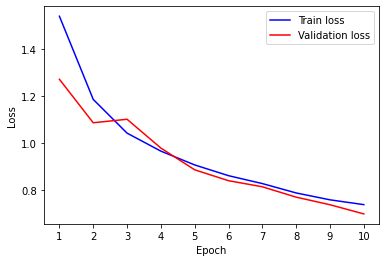

In [12]:
model_CSP = CSPNet()
model_CSP = model_CSP.to(device=device)

optimizer = torch.optim.Adam(model_CSP.parameters(), lr=LEARNING_RATE)

training(model_CSP, optimizer)

plt.figure(0)
plt.plot(list(range(1,EPOCHS+1)), training_losses, 'b')
plt.plot(list(range(1,EPOCHS+1)), validation_losses, 'r')
plt.xticks(list(range(1,EPOCHS+1)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()

In [13]:
def testing(model):
    model.eval()
    
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for x_test, y_test in testing_dataloader:
            x_test = x_test.to(device=device, dtype=torch.float32)
            y_test = y_test.to(device=device, dtype=torch.long)
            
            _,pred = model(x_test).max(1)
            
            correct_preds += (pred==y_test).sum()
            total_preds   += pred.size(0)
            
    accuracy = 100 * torch.true_divide(correct_preds,total_preds)
    print('Correct predictions {}/{}, accuracy = {:.2f}%.'.format(correct_preds, total_preds, accuracy))
    
testing(model_CSP)

Correct predictions 7441/10000, accuracy = 74.41%.


In [ ]:
# Save weights if desired
# torch.save(model_CSP.state_dict(), 'CSPNetModel.pt')